In [1]:
import numpy as np
from DataFlowModel import GenerateGraph, CreateTree, GeneratePrecisionGraph



IT is quantised


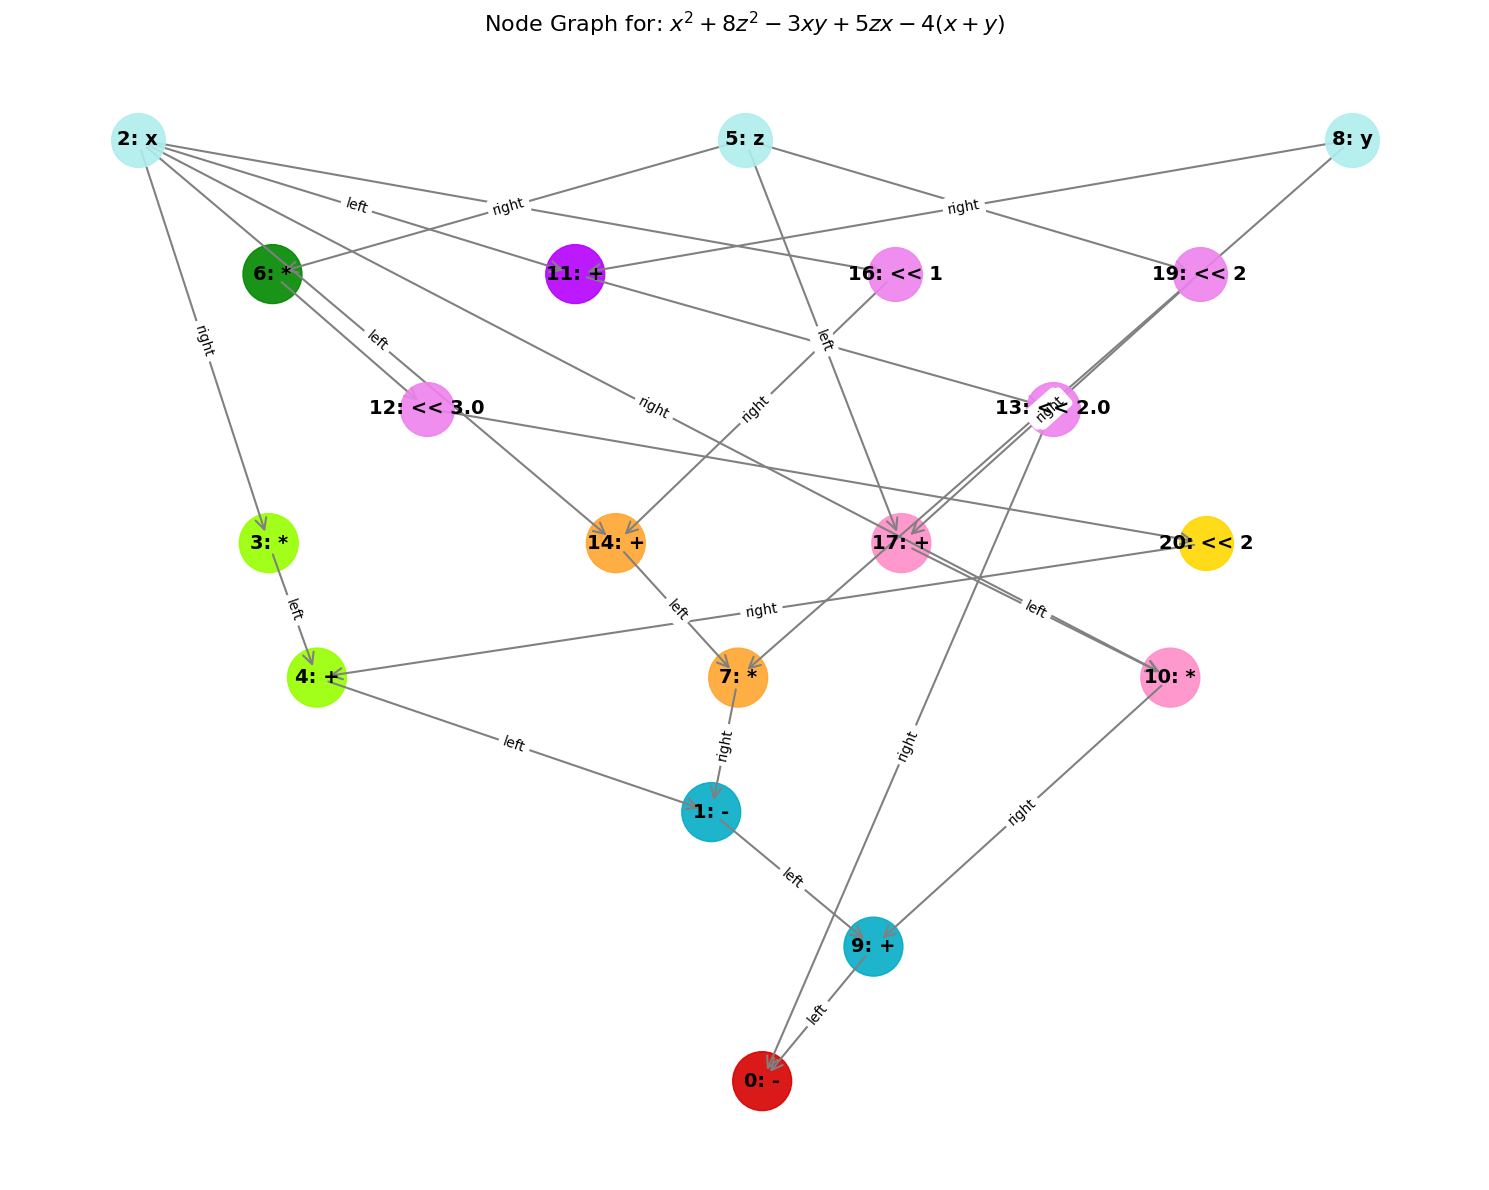

Initial values {2: 2, 5: 4, 8: 3}
{2: 2, 5: 4, 8: 3}
Node:  16
operation:  << 1
To shift:  000000001000
000000010000
{2: '000000001000', 5: '000000010000', 8: '000000001100', 16: '000000010000'}
{16: 4.0}
{2: 2, 5: 4, 8: 3, 16: 4.0}
Node:  6
operation:  *
24
End of DSP with mult
Calculation power:  0000000000000000000000000000000000100000000
We need to truncate here
00000000000000000000000000000000001000000
{2: '000000001000', 5: '000000010000', 8: '000000001100', 16: '000000010000', 6: '00000000000000000000000000000000001000000'}
{16: 4.0, 6: 16.0}
{2: 2, 5: 4, 8: 3, 16: 4.0, 6: 16.0}
Node:  19
operation:  << 2
To shift:  000000010000
000001000000
{2: '000000001000', 5: '000000010000', 8: '000000001100', 16: '000000010000', 6: '00000000000000000000000000000000001000000', 19: '000001000000'}
{16: 4.0, 6: 16.0, 19: 16.0}
{2: 2, 5: 4, 8: 3, 16: 4.0, 6: 16.0, 19: 16.0}
Node:  11
operation:  +
+ {2: '000000001000', 5: '000000010000', 8: '000000001100', 16: '000000010000', 6: '0000000000000

In [53]:
import numpy as np
import fixedpoint as fp
import matplotlib.pyplot as plt
import operator
import re

def end_dsp_block(node, dsp_combos):

    for combo in dsp_combos:
        last_node = combo[-1]
        
        if node == last_node:
            return True
    
    return False


def last_node_in_dsp(G, node, dsp_combos):
    for combo in dsp_combos:
        operations = [G.nodes[s]['label'] for s in combo]
        if '*' in operations:
            
            #print(operations)
            if node == combo[-1]:
                print("End of DSP with mult")
                return True
        
    return False


def mult_postadder_use(G, node, dsp_combos):
    print(dsp_combos)
    for combo in dsp_combos:
        if len(combo) > 1:
            if last_node_in_dsp(G, node, dsp_combos) and G.nodes[combo[-2]]['label'] == '*':
                print('End of DSP Block with multiplier and poastadder')
                # print(G.nodes[combo[-2]]['label'])
                # print(combo[-1])
                # if G.nodes[combo[-2]]['label'] == '*' and node == combo[-1]:

                return True
    
    return False



# print(mult_postadder_use(G_mod, 15, dsp_combos))

def twos_complement_to_int(val_str):
    val = int(val_str, 2)
    bits = len(val_str)
    if (val & (1 << (bits - 1))) != 0: 
        val = val - (1 << bits)        
    return val                        

def int_to_twos_complement(num, bits):
    if num >= 0:
        return format(num, f'0{bits}b')
    else:
        return format((1 << bits) + num, f'0{bits}b')
    

def dsp_mult(a, b):
    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    product = a_int * b_int

    product_bin = int_to_twos_complement(product, len(a) + len(b))
    print(len(product_bin))

    if len(product_bin) < 43:
        sign_bit = product_bin[0]
        pad_len = 43 - len(product_bin)
        product_bin = (sign_bit * pad_len) + product_bin

    if len(product_bin) >= 43:
        final_product = product_bin[:43]
    else:
        final_product = product_bin

    return final_product

def dsp_add(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    sum = a_int + b_int
    sum_bin = int_to_twos_complement(sum, max(len(a), len(b)) + 1)

    return sum_bin

def dsp_subtract(a, b):

    a_int = twos_complement_to_int(a)
    b_int = twos_complement_to_int(b)

    diff = a_int - b_int
    diff_bin = int_to_twos_complement(diff, max(len(a), len(b)) + 1)

    return diff_bin


def arithmetic_shift(val_str, shifts):
    val = twos_complement_to_int(val_str)

    if shifts > 0:
        shifted = val << shifts
    elif shifts < 0:
        shifted = val >> -shifts

    shifted_bin = int_to_twos_complement(shifted, len(val_str))

    if shifted_bin[0] =='b':
        shifted_bin = shifted_bin[1:]
    
    return shifted_bin


# Starting nodes
# print(split_stage_levels)









def calculate_expression(G, new_levels, initial_values, quant_initial_values, dsp_combos, m, n, quantised = False):

    converted_node_results = {}
    print("Initial values", initial_values)

    ops = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul
    }
    
    if quantised:
        node_results = quant_initial_values  # Use binary strings
        number_node_results = initial_values  # Keep numeric values separate
    else:
        node_results = initial_values
        number_node_results = {}

   

    print(number_node_results)

    # First part is using the graph to compute a result with floating point


    for th in range(1, max(new_levels.values()) + 1):
        
        th_level = [node for node, level in new_levels.items() if level == th]

        for item in th_level:
            print("Node: ", item)
            truncate_multiplication = False

            preds = list(G.predecessors(item))

            operation = G.nodes[item]['label']

            print("operation: ", operation)


            if operation in ('+', '-', '*'):

                right = [u for u, v, attr in G.in_edges(item, data=True) if attr['label'] == 'right']
                left = [u for u, v, attr in G.in_edges(item, data=True) if attr['label'] == 'left']
            
                if operation == '*' and len(preds) == 1:

                    if quantised:

                        calculation = dsp_mult(node_results[preds[0]], node_results[preds[0]])
                        number_calculation = number_node_results[preds[0]]**2

                        if last_node_in_dsp(G, item, dsp_combos):
                            truncate_multiplication = True
                        
                        #calculation = fp.FixedPoint(node_results[preds[0]]**2, signed = True, m = m, n = n, str_base = 2)
                    else:
                        calculation = node_results[preds[0]]**2


                    print("Calculation power: ", calculation)

                else:

                    print(operation, node_results)

                    left_value = node_results[left[0]]
                    right_value = node_results[right[0]]

                    print(left_value, right_value)

                    if quantised:
                        if operation == '*':
                            calculation = dsp_mult(left_value, right_value)
                        elif operation =='+':

                            if mult_postadder_use(G, item, dsp_combos):
                                print("here")
                                print(left_value)
                                # left_value = left_value.ljust(len(left_value) + n, '0')
                                # print("Extended left: ", left_value)

                            calculation = dsp_add(left_value, right_value)
                            print("Calculation addition", left_value, right_value, calculation)

                        elif operation == '-':
                            if mult_postadder_use(G, item, dsp_combos):
                                print("here")
                                print(left_value)
                                left_value = left_value.ljust(len(left_value) + n, '0')
                                print("Extended left: ", left_value)

                            calculation = dsp_subtract(left_value, right_value)
                            
                        #calculation = fp.FixedPoint(ops[operation](left_value, right_value), signed = True, m = m, n = n, str_base = 2)
                        
                        #End of DSP block with a multiplier, truncate 2n frac bits
                        if last_node_in_dsp(G, item, dsp_combos):
                            truncate_multiplication = True

                        left_value = number_node_results[left[0]]
                        right_value = number_node_results[right[0]]
                        number_calculation = ops[operation](left_value, right_value)
                    else:
                        calculation = ops[operation](left_value, right_value)

                    print(calculation)

            elif '<<' in operation or'>>' in operation:
                match = re.search(r'(<<|>>)\s*(\d+)', operation)
                direction, exponent = match.groups()

                if direction == '>>':
                    exponent = - int(exponent)

                else:
                    exponent = int(exponent)
                
                if quantised:
                    print("To shift: ", node_results[preds[0]])
                    calculation = arithmetic_shift(node_results[preds[0]], exponent)
                    # q_val = fp.FixedPoint(node_results[preds[0]], signed = True, m = m, n = n, str_base = 2)
                    # q_shifted = q_val << exponent
                    # calculation = fp.FixedPoint(q_shifted, signed = True, m = m, n = n, str_base = 2)
                    # print(float(q_val))
                    # print(q_val)

                    number_calculation = number_node_results[preds[0]] * (2 ** exponent)


                else:
                    calculation = node_results[preds[0]] * (2 ** exponent)

                print(calculation)

            
            if quantised:
                if truncate_multiplication:
                    # Multiplication was used meaning that 2n fractional bits have to be cut down to n fractional bits
                    print("We need to truncate here")
                    print(calculation[:-(n)])
                    calculation = calculation[:-(n)]

            

            
            if quantised:
                node_results[item] = str(calculation)

                number_node_results[item] = float(number_calculation)
            else:
                print(float(calculation))
                node_results[item] = float(calculation)

            if quantised:
                v = node_results[item]
                converted_node_results[item] = float(fp.FixedPoint("0b" + str(v), signed = True, m = len(v) - n, n = n, str_base = 2))

            print(node_results)
            print(converted_node_results)
            print(number_node_results)

    print("Node result: ", node_results)

    if quantised:
        # Fetches deepest node
        item = max(new_levels, key=new_levels.get)
        v  = node_results[item]
        print(float(fp.FixedPoint("0b" + str(v), signed = True, m = len(v) - n, n = n, str_base = 2)))



def initial_values(G, new_levels, value_mapping, quant_value_mapping):


    # starting_nodes = [node for node, level in new_levels.items() if level == 0]
    starting_nodes = []

    for node, level in new_levels.items():
        if level == 0:
            starting_nodes.append((node, G.nodes[node]['label']))

    vars = {node_num: value_mapping[var_name] for node_num, var_name in starting_nodes}
    quant_vars = {node_num: quant_value_mapping[var_name] for node_num, var_name in starting_nodes}
                                
    return vars, quant_vars




user_input = "x^2 + 8*z^2 - 3*x*y + 5*z*x - 4*(x+y)"

# user_input = "4*x + 2*y + z^2"

quant = True
m = 10
n = 2

G_mod, dsp_combos, split_stage_levels = GeneratePrecisionGraph(user_input, frac_bit_num = n, show_graph = True, quantised = quant)

quant_value_mapping = {'x': "000000001000", 'y': "000000001100", 'z': "000000010000"}

value_mapping = {'x': 2, 'y': 3, 'z': 4}




init_val, quant_init_val = initial_values(G_mod, split_stage_levels, value_mapping, quant_value_mapping)
calculate_expression(G_mod, split_stage_levels, init_val, quant_init_val, dsp_combos, quantised = quant, m = n, n = n)

## Next step is to do the same calculation but the fixed point arithmetic

np_init_values = np.array([2, 3, 4])

x, y, z = np_init_values[0], np_init_values[1], np_init_values[2]

# Convert ^ to ** for Python exponentiation
result = eval(user_input.replace('^', '**'))
print("Calculation result:", result)



In [ ]:
_